# Uitwerkingen H7: 7.49

In [382]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon, Arc


In [383]:
puntlasten = np.array([[]])  # [position (m), magnitude (kN)]
koppel = np.array([[]])  # [position (m), magnitude (kNm)]
verdeeldeBelasting = np.array([[]])  # [start position (m), end position (m), magnitude (kN/m)]

lengteBalk = 6.0    # lengte van de balk [m]
A = 0.0         # positie oplegging A (rol) [m]
B = 6.0        # positie oplegging B (scharnier) [m]

puntlasten = np.array([ [2, 0, -15], ])  # [position (m), magnitude (kN)]
#koppel = np.array([[3, 20]])  # [position (m), magnitude (kNm)]
verdeeldeBelasting = np.array([[4, 6, -10]])  # [start position (m), end position (m), magnitude (kN/m)]

divs = 10000  # aantal deelstukken voor de balk
dx = lengteBalk / divs  # lengte van een deelstuk [m]
X = np.arange(0, lengteBalk + 2*dx, dx)  # x-coordinaten van de deelstukken [m]
nPL = len(puntlasten[0])  # aantal puntlasten
nPM = len(koppel[0])  # aantal puntmomenten
nVB = len(verdeeldeBelasting[0])  # aantal verdeelde lasten

reactieKrachten = np.array([0.0,0.0,0.0])  # [Va (kN), Ha (kN), Vb (kN)]
shearForce = np.empty([0,len(X)])  # schuifkracht langs de balk [kN]
bendingMoment = np.empty([0,len(X)])  # buigend moment langs de balk [k


In [384]:
def reactie_PL(n):
    xp = puntlasten[n,0]
    fx = puntlasten[n,1]
    fy = puntlasten[n,2]

    la_p = A - xp
    mp = fy * la_p
    la_vb = B - A

    Vb = mp / la_vb
    Va = -fy - Vb
    Ha = -fx

    return Va, Vb, Ha

def reactie_PM(n):
    xm = koppel[n,0]
    m = koppel[n,1]

    la_vb = B - A

    Vb = m / la_vb
    Va = - Vb

    return Va, Vb

def reactie_VB(n):
    xStart = verdeeldeBelasting[n,0]
    xEnd = verdeeldeBelasting[n,1]
    fy = verdeeldeBelasting[n,2]

    fy_Res = fy * (xEnd - xStart)  # resulterende kracht van de UDL
    x_Res = xStart + 0.5 * (xEnd - xStart)  # positie van de resulterende kracht van de UDL    

    la_p = A - x_Res
    mp = fy_Res * la_p
    la_vb = B - A

    Vb = mp / la_vb
    Va = - fy_Res - Vb

    return Va, Vb

In [385]:
PL_record = np.empty([0,3])  # [Va (kN), Vb (kN), Ha (kN)]
if (nPL > 0):

    for n, p in enumerate(puntlasten):
        va, vb, ha = reactie_PL(n)
        PL_record = np.append(PL_record, [np.array([va, ha, vb])], axis=0)

        reactieKrachten[0] += va
        reactieKrachten[1] += ha
        reactieKrachten[2] += vb

PM_record = np.empty([0,2])  # [Va (kN), Vb (kN), Ha (kN)]
if (nPM > 0):
    for n, p in enumerate(koppel):
        va, vb = reactie_PM(n)
        PM_record = np.append(PM_record, [np.array([va, vb])], axis=0)

        reactieKrachten[0] += va
        #reactieKrachten[1] += ha
        reactieKrachten[2] += vb

VB_record = np.empty([0,2])  # [Va (kN), Vb (kN), Ha (kN)]
if (nVB > 0):
    for n, p in enumerate(verdeeldeBelasting):
        va, vb = reactie_VB(n)
        VB_record = np.append(VB_record, [np.array([va, vb])], axis=0)

        reactieKrachten[0] += va
        #reactieKrachten[1] += ha
        reactieKrachten[2] += vb

In [386]:
def shear_moment_PL(n):
    xp = puntlasten[n,0]
    #fx = puntlasten[n,1]
    fy = puntlasten[n,2]
    Va = PL_record[n,0]
    Vb = PL_record[n,2]

    Shear = np.zeros(len(X))
    Moment = np.zeros(len(X))

    for i, x in enumerate(X):
        shear = 0
        moment = 0

        if x > A:
            shear = shear + Va
            moment = moment + Va * (x - A)

        if x > xp:
            shear = shear + fy
            moment = moment + fy * (x - xp)

        if x > B:
            shear = shear + Vb
            moment = moment + Vb * (x - B)

        Shear[i] = shear
        Moment[i] = moment

    return Shear, Moment

def shear_moment_PM(n):
    xm = koppel[n,0]
    m = koppel[n,1]
    Va = PM_record[n,0]
    Vb = PM_record[n,1]

    Shear = np.zeros(len(X))
    Moment = np.zeros(len(X))

    for i, x in enumerate(X):
        shear = 0
        moment = 0

        if x > A:
            shear = shear + Va
            moment = moment + Va * (x - A)

        if x > xm:
            moment = moment + m

        if x > B:
            shear = shear + Vb
            moment = moment + Vb * (x - B)

        Shear[i] = shear
        Moment[i] = moment

    return Shear, Moment

def shear_moment_UDL(n):
    xStart = verdeeldeBelasting[n,0]
    xEnd = verdeeldeBelasting[n,1]
    fy = verdeeldeBelasting[n,2]
    Va = VB_record[n,0]
    Vb = VB_record[n,1]

    Shear = np.zeros(len(X))
    Moment = np.zeros(len(X))

    for i, x in enumerate(X):
        shear = 0
        moment = 0

        if x > A:
            shear = shear + Va
            moment = moment + Va * (x - A)

        if x > B:
            shear = shear + Vb
            moment = moment + Vb * (x - B)
        
        if x > xStart and x <= xEnd :
            shear = shear + fy * (x - xStart)
            moment = moment + fy * (x - xStart) * 0.5 * (x - xStart)
        elif( x > xEnd ):
            shear = shear + fy * (xEnd - xStart)
            moment = moment + fy * (xEnd - xStart) * (x-xStart - 0.5 * (xEnd - xStart))



        Shear[i] = shear
        Moment[i] = moment

    return Shear, Moment

In [387]:
if (nPL > 0):
    for n, p in enumerate(puntlasten):
        Shear, Moment = shear_moment_PL(n)
        shearForce = np.append(shearForce, [Shear], axis=0)
        bendingMoment = np.append(bendingMoment, [Moment], axis=0)

if (nPM > 0):
    for n, p in enumerate(koppel):
        Shear, Moment = shear_moment_PM(n)
        shearForce = np.append(shearForce, [Shear], axis=0)
        bendingMoment = np.append(bendingMoment, [Moment], axis=0)

if (nVB > 0):
    for n, p in enumerate(verdeeldeBelasting):
        Shear, Moment = shear_moment_UDL(n)
        shearForce = np.append(shearForce, [Shear], axis=0)
        bendingMoment = np.append(bendingMoment, [Moment], axis=0)

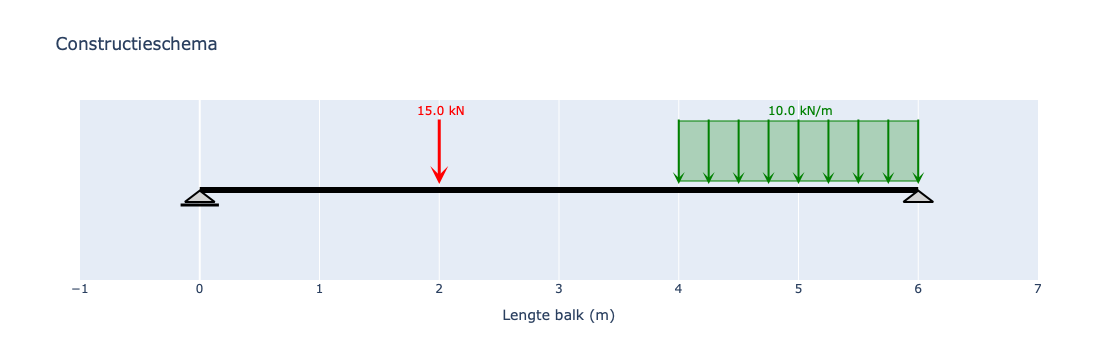

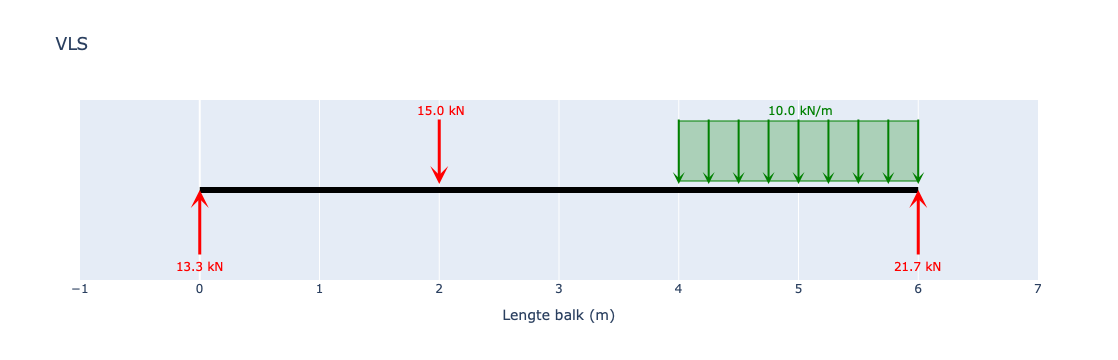

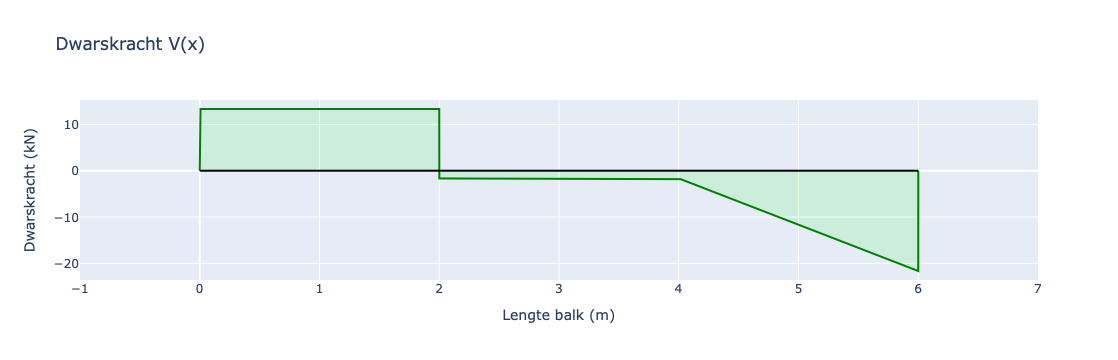

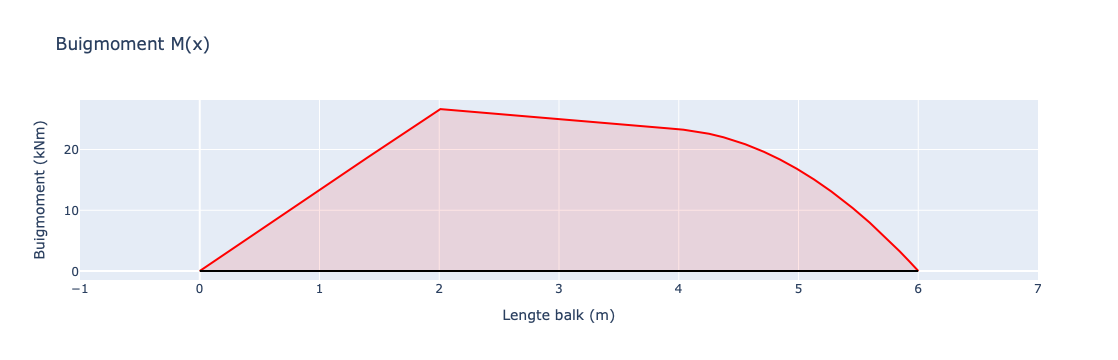

In [388]:
import numpy as np
import math
import plotly.graph_objects as go

# ============ Plotly schema helpers ============
# (Schematische tekening: constructieschema + VLS)

# --- algemene styling / geometrie (zelfde als in je matplotlib-versie) ---
ticks = np.arange(0, lengteBalk + 1, 1)

blok_y0 = 0.05
blok_hoogte = 1
pijl_start_y = blok_y0 + blok_hoogte
pijl_dy = -1
aantal_pijlen = 9

tri_half = 0.125
tri_base_y = -0.20
tri_apex_y = -0.01
rol_line_y = tri_base_y - 0.05
rol_line_halfwidth = 0.16


def _base_fig(title: str):
    fig = go.Figure()
    fig.update_layout(
        title=title,
        margin=dict(l=40, r=20, t=60, b=40),
        showlegend=False,
        xaxis=dict(
            title="Lengte balk (m)",
            range=[-1, lengteBalk + 1],
            autorange=False,
        ),
        yaxis=dict(
            range=[-1.5, 1.5],
            autorange=False,
            showticklabels=False,
            showgrid=False,
            zeroline=False,
        ),
    )
    return fig



def _add_poly(fig, xs, ys, fillcolor="gray", linecolor="black", opacity=1.0):
    fig.add_trace(go.Scatter(
        x=xs, y=ys,
        mode="lines",
        fill="toself",
        fillcolor=fillcolor,
        line=dict(color=linecolor, width=2),
        opacity=opacity,
        hoverinfo="skip"
    ))


def _add_line(fig, x0, y0, x1, y1, color="black", width=4):
    fig.add_trace(go.Scatter(
        x=[x0, x1], y=[y0, y1],
        mode="lines",
        line=dict(color=color, width=width),
        hoverinfo="skip"
    ))


def _add_arrow(fig, x0, y0, x1, y1, color="black", width=2, head=3):
    fig.add_annotation(
        x=x1, y=y1, ax=x0, ay=y0,
        xref="x", yref="y", axref="x", ayref="y",
        showarrow=True,
        arrowcolor=color,
        arrowwidth=width,
        arrowhead=head,
        arrowsize=1,
        text="",
    )


def teken_balk_plotly(fig):
    _add_line(fig, 0, 0, lengteBalk, 0, color="black", width=6)


def teken_opleggingen_plotly(fig):
    # Roloplegging bij A (driehoek + lijn)
    _add_poly(
        fig,
        [A - tri_half, A + tri_half, A - 0.0, A - tri_half],
        [tri_base_y,  tri_base_y,  tri_apex_y, tri_base_y],
        fillcolor="lightgray",
        linecolor="black",
        opacity=1.0,
    )
    _add_line(fig, A - rol_line_halfwidth, rol_line_y, A + rol_line_halfwidth, rol_line_y, color="black", width=3)

    # Scharnieroplegging bij B (driehoek)
    _add_poly(
        fig,
        [B - tri_half, B + tri_half, B - 0.0, B - tri_half],
        [tri_base_y,  tri_base_y,  tri_apex_y, tri_base_y],
        fillcolor="lightgray",
        linecolor="black",
        opacity=1.0,
    )


def teken_verdeelde_belasting_plotly(fig):
    """Gebruik `verdeeldeBelasting`: [xStart, xEnd, q] (kN/m)."""

    if nVB <= 0:
        return

    y_balk = 0.1          # <-- zet dit gelijk aan de y van je balk als die niet 0 is
    L_pijl = 1.1          # lengte van de pijlen
    label_offset = 0.15   # label altijd boven de pijlen

    for vb in verdeeldeBelasting:
        if vb.size == 0:
            continue

        xStart, xEnd, q = vb
        xStart, xEnd, q = float(xStart), float(xEnd), float(q)

        if xEnd <= xStart or abs(q) < 1e-9:
            continue

        # (optioneel) groen blok boven de balk, puur visueel
        fig.add_shape(
            type="rect",
            x0=xStart, x1=xEnd,
            y0=y_balk + 0.05, y1=y_balk + 0.05 + 1.0,   # vergelijkbaar met jouw blok_y0/blok_hoogte
            line=dict(color="green", width=1),
            fillcolor="rgba(0,128,0,0.25)",
        )

        xs = np.linspace(xStart, xEnd, aantal_pijlen)

        for x in xs:
            if q < 0:
                # NEGATIEF: head op balk, pijl naar beneden (staart erboven)
                x0, y0 = x, y_balk + L_pijl   # staart
                x1, y1 = x, y_balk            # head op balk
            else:
                # POSITIEF: staart op balk, pijl naar boven (head erboven)
                x0, y0 = x, y_balk            # staart op balk
                x1, y1 = x, y_balk + L_pijl   # head

            _add_arrow(fig, float(x0), float(y0), float(x1), float(y1), color="green", width=2)

        # Label ALTIJD boven (zoals je bij puntlast wilde)
        fig.add_annotation(
            x=(xStart + xEnd) / 2,
            y=y_balk + L_pijl + label_offset,
            text=f" {abs(q):.1f} kN/m",
            showarrow=False,
            font=dict(color="green"),
        )



def teken_puntlasten_plotly(fig):
    """
    Puntlasten tekenen met vaste locatie op de balk:
    - P < 0: pijlpunt op de balk, pijl wijst omlaag, label boven de balk
    - P > 0: staart op de balk, pijl wijst omhoog, label boven de balk

    Verwacht:
    - puntlasten: per rij [x, ..., P]
    - nPL: aantal puntlasten
    - _add_arrow(fig, x0,y0,x1,y1, ...)
    """

    if nPL <= 0:
        return

    y_balk = 0.1          # <-- zet dit op jouw balk-y als die niet 0 is
    L_pijl = 1.1          # pijllengte
    label_offset = 0.15   # label afstand boven balk

    for pl in puntlasten:
        if pl.size == 0:
            continue

        xP = float(pl[0])
        P  = float(pl[-1])

        if abs(P) < 1e-9:
            continue

        if P < 0:
            # NEGATIEF: head (pijlpunt) op de balk, staart erboven, pijl wijst naar beneden
            x0, y0 = xP, y_balk + L_pijl   # staart
            x1, y1 = xP, y_balk            # head op balk
        else:
            # POSITIEF: staart op de balk, head erboven, pijl wijst naar boven
            x0, y0 = xP, y_balk            # staart op balk
            x1, y1 = xP, y_balk + L_pijl   # head

        _add_arrow(fig, x0, y0, x1, y1, color="red", width=3)

        # Label ALTIJD boven de balk (zoals jij wilt)
        fig.add_annotation(
            x=xP,
            y=y_balk + L_pijl + label_offset,
            text=f" {abs(P):.1f} kN",
            showarrow=False,
            font=dict(color="red"),
        )





def teken_koppels_plotly(fig):
    """Gebruik `koppel`: [x, M] (kNm)."""
    if nPM > 0:
        for km in koppel:
            if km.size == 0:
                continue
            xC = float(km[0])
            M_C = float(km[-1])
            if abs(M_C) < 1e-9:
                continue

            radius = 0.35
            # boog benaderen met punten
            theta = np.linspace(math.radians(40), math.radians(320), 60)
            xs = xC + radius * np.cos(theta)
            ys = 0.0 + radius * np.sin(theta)

            fig.add_trace(go.Scatter(
                x=xs, y=ys,
                mode="lines",
                line=dict(color="purple", width=3),
                hoverinfo="skip",
            ))

            # pijlhead (tangent richting)
            # neem laatste twee punten voor richting
            x0, y0 = xs[-2], ys[-2]
            x1, y1 = xs[-1], ys[-1]
            _add_arrow(fig, float(x0), float(y0), float(x1), float(y1), color="purple", width=3, head=3)

            fig.add_annotation(
                x=xC,
                y=-0.18,
                text=f"M = {M_C:.1f} kNm",
                showarrow=False,
                font=dict(color="purple"),
            )


def teken_reactiekrachten_plotly(fig):
    """Gebruik `reactieKrachten = [Va, Ha, Vb]`.
    
    Eisen:
    - Reactiekrachten altijd onder de balk
    - R > 0: pijlpunt omhoog
    - R < 0: pijlpunt omlaag
    - Plek (anker) blijft hetzelfde
    - Waarde altijd onder de pijl
    """

    Va, Ha, Vb = reactieKrachten

    y_balk = 0.0            # <-- zet gelijk aan balk-y als die niet 0 is
    y_anker = y_balk - 1.1   # vaste plek ONDER de balk (hier zit de pijl "vast")
    L_pijl = 1.1             # pijllengte
    label_offset = 0.15      # label onder de pijl

    for xpos, R in [(A, Va), (B, Vb)]:
        R = float(R)
        if abs(R) < 1e-9:
            continue

        if R > 0:
            # pijlpunt omhoog: head boven staart
            x0, y0 = float(xpos), y_anker           # staart (anker onder)
            x1, y1 = float(xpos), y_anker + L_pijl  # head omhoog
        else:
            # pijlpunt omlaag: head onder staart
            x0, y0 = float(xpos), y_anker           # staart (anker onder)
            x1, y1 = float(xpos), y_anker - L_pijl  # head omlaag

        _add_arrow(fig, x0, y0, x1, y1, color="red", width=3)

        # waarde altijd onder de pijl (dus onder het laagste punt)
        y_label = min(y0, y1) - label_offset

        fig.add_annotation(
            x=float(xpos),
            y=float(y_label),
            text=f"{R:.1f} kN",
            showarrow=False,
            font=dict(color="red"),
        )



#def maak_constructieschema_plotly():
 #   fig = _base_fig("Constructieschema")
  #  teken_balk_plotly(fig)
   # teken_opleggingen_plotly(fig)
    #teken_verdeelde_belasting_plotly(fig)
    #teken_puntlasten_plotly(fig)
    #teken_koppels_plotly(fig)
    #return fig

layout_common = dict(
    xaxis=dict(title="Lengte balk (m)", range=[-1, lengteBalk+1], autorange=False),
    showlegend=False,
    #margin=dict(l=40, r=20, t=60, b=40),
)

def maak_constructieschema_plotly():
    fig = go.Figure()
    fig.update_layout(title="Constructieschema", **layout_common)
    fig.update_yaxes(range=[-1.5, 1.5], autorange=False, showticklabels=False, showgrid=False, zeroline=False, title=None)
    teken_balk_plotly(fig)
    teken_opleggingen_plotly(fig)
    teken_puntlasten_plotly(fig)
    teken_verdeelde_belasting_plotly(fig)
    return fig

def maak_vls_plotly():
    fig = go.Figure()
    fig.update_layout(title="VLS", **layout_common)
    fig.update_yaxes(range=[-1.5, 1.5], autorange=False, showticklabels=False, showgrid=False, zeroline=False, title=None)
    teken_balk_plotly(fig)
    #teken_opleggingen_plotly(fig)
    teken_puntlasten_plotly(fig)
    teken_verdeelde_belasting_plotly(fig)
    teken_reactiekrachten_plotly(fig)
    return fig
    


# --- toon de figuren ---
fig_schema = maak_constructieschema_plotly()
fig_vls = maak_vls_plotly()
fig_schema.show()
fig_vls.show()

layout = go.Layout(
    title="Dwarskracht V(x)",
    xaxis=dict(title="Lengte balk (m)", range=[-1, lengteBalk+1]),
    yaxis=dict(title="Dwarskracht (kN)"),
    showlegend=False
)

line = go.Scatter(
    x=X,
    y= sum(shearForce),
    mode='lines',
    name='Dwarskracht (kN)',
    fill = 'tonexty',
    line_color='green',
    fillcolor='rgba(0,255,0,0.1)'
)

axis = go.Scatter(
    x= [0,lengteBalk],
    y= [0,0],
    mode='lines',
    line_color='black'
)

fig= go.Figure(data=[line, axis], layout=layout)
fig.show()


layout = go.Layout(
    title="Buigmoment M(x)",
    xaxis=dict(title="Lengte balk (m)", range=[-1, lengteBalk+1]),
    yaxis=dict(title="Buigmoment (kNm)"),
    showlegend=False
)

line = go.Scatter(
    x=X,
    y= sum(bendingMoment),
    mode='lines',
    name='Buigmoment (kNm)',
    fill = 'tonexty',
    line_color='red',
    fillcolor='rgba(255,0,0,0.1)'
)

axis = go.Scatter(
    x= [0,lengteBalk],
    y= [0,0],
    mode='lines',
    line_color='black'
)

fig= go.Figure(data=[line, axis], layout=layout)
fig.show()